## Imports

In [1]:
!pip install medmnist
!pip install wandb
!pip install transformers
!pip install -q --upgrade transformers
!pip install pillow
!pip install evaluate
!pip install torch
!pip install optuna
!pip install wandb


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!wandb login


wandb: Currently logged in as: mlabrie0208 (mlabrie0208-polytechnique-montr-al) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [4]:
import numpy as np
import torch
import sys
print(torch.cuda.is_available())
from torch.utils.data import Dataset, random_split, DataLoader
from transformers import (
    ViTHybridImageProcessor,
    ViTHybridForImageClassification,
    TrainingArguments,
    Trainer,
)
import transformers
print(transformers.__version__)
from medmnist import INFO
from medmnist.dataset import MedMNIST
import medmnist.dataset as mds
from PIL import Image
import evaluate
from medmnist import PathMNIST, DermaMNIST, BloodMNIST, RetinaMNIST
sys.path.append('/content/drive/MyDrive/Project_Deep_Learning')
from data_augmentation import *
from evaluate import load



True
4.51.3


# Loading Dataset

In [6]:
# Download and load datasets
print("Downloading datasets...")
path_dataset = PathMNIST(split="train", download=True, as_rgb=True)
derma_dataset = DermaMNIST(split="train", download=True, as_rgb=True)
blood_dataset = BloodMNIST(split="train", download=True, as_rgb=True)
retina_dataset = RetinaMNIST(split="train", download=True, as_rgb=True)

val_path_dataset = PathMNIST(split="val", download=True)
val_derma_dataset = DermaMNIST(split="val", download=True)
val_blood_dataset = BloodMNIST(split="val", download=True)
val_retina_dataset = RetinaMNIST(split="val", download=True)

test_path_dataset = PathMNIST(split="test", download=True)
test_derma_dataset = DermaMNIST(split="test", download=True)
test_blood_dataset = BloodMNIST(split="test", download=True)
test_retina_dataset = RetinaMNIST(split="test", download=True)

# Create a unified label set across the datasets
pathmnist_info = INFO["pathmnist"]
dermamnist_info = INFO["dermamnist"]
bloodmnist_info = INFO["bloodmnist"]
retinamnist_info = INFO["retinamnist"]

labels = set(pathmnist_info["label"].values())
labels.update(dermamnist_info["label"].values())
labels.update(bloodmnist_info["label"].values())
labels.update(retinamnist_info["label"].values())
labels = sorted(list(labels))
num_labels = len(labels)
print("Number of unique labels:", num_labels)


Number of unique labels: 29


In [7]:
import torchvision.transforms as T
class CustomMNIST(Dataset):
  def __init__(self, dataset, *args, **kwargs):

    super(CustomMNIST, self).__init__()

    self.data_transform = transforms.Compose([
      transforms.Resize((384, 384)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[.5], std=[.5])
      ])

    self.dataset = dataset
    self.transform = T.ToPILImage()

  def __len__(self):
    return len(self.dataset)


  def __getitem__(self, idx):
    image, label = self.dataset[idx]

    if isinstance(image, torch.Tensor):
          image = self.transform(image)

    image = self.data_transform(image)

    item = {'pixel_values' : image, 'labels' : label}
    return item

In [8]:
train_subset = 1080
concat_dataset = ConcatDataset(path_dataset, derma_dataset, blood_dataset, retina_dataset, train_subset)
#augmented_dataset = DatasetAugmentation(concat_dataset)
train_dataset = CustomMNIST(concat_dataset)

validation_subset = 120
concat_val_dataset = ConcatDataset(val_path_dataset, val_derma_dataset, val_blood_dataset, val_retina_dataset, validation_subset)
val_dataset = CustomMNIST(concat_val_dataset)

test_subset = 400
concat_test_dataset = ConcatDataset(test_path_dataset, test_derma_dataset, test_blood_dataset, test_retina_dataset, test_subset)
test_dataset = CustomMNIST(concat_test_dataset)

Concatenating datasets
Concatenating datasets
Concatenating datasets


In [9]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

4320
480
1600


# Training

## Loading models

In [10]:
feature_extractor = ViTHybridImageProcessor.from_pretrained('google/vit-hybrid-base-bit-384')
baseline_model = ViTHybridForImageClassification.from_pretrained('google/vit-hybrid-base-bit-384')

baseline_model.config.num_labels = num_labels


model = ViTHybridForImageClassification.from_pretrained('google/vit-hybrid-base-bit-384')
model.config.num_labels = num_labels

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [11]:
import math
batch_size = 32
grad_accum = 1

steps_per_epoch = math.ceil(
    len(train_dataset)
    / (batch_size * grad_accum)
)


In [12]:
import transformers, inspect, textwrap, sys
print("transformers version -->", transformers.__version__)
print("TrainingArguments is defined in -->", inspect.getfile(transformers.TrainingArguments))


transformers version --> 4.51.3
TrainingArguments is defined in --> /usr/local/lib/python3.11/dist-packages/transformers/training_args.py


## Hyper Parameter search and training of best model

In [13]:
accuracy_metric  = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric    = evaluate.load("recall")
f1_metric        = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    accuracy  = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    precision = precision_metric.compute(predictions=preds, references=labels, average="weighted", zero_division=0)["precision"]
    recall    = recall_metric.compute(predictions=preds, references=labels, average="weighted", zero_division=0)["recall"]
    f1        = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]

    return {
        "accuracy":  accuracy,
        "precision": precision,
        "recall":    recall,
        "f1":        f1
    }


In [14]:

from transformers import Trainer, TrainingArguments
import optuna

import os

# all runs go into this projec
os.environ["WANDB_PROJECT"]   = "vit-hybrid-medmnist"
os.environ["WANDB_RUN_GROUP"] = "hpsearch2"

def model_init():
    model =  ViTHybridForImageClassification.from_pretrained("google/vit-hybrid-base-bit-384")
    model.config.num_labels = num_labels
    return model

def hp_space(trial: optuna.Trial):
    return {
        # try LR between 5e‑6 and 5e‑5, log scale
        "learning_rate": trial.suggest_float("learning_rate", 5e-6, 5e-4, log=True),
        # weight decay
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.1),
        # warmup ratio
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.2),
    }

training_args = TrainingArguments(
    output_dir="./vit-hybrid-medmnist-hpsearch",
    num_train_epochs=10,
    eval_strategy="steps",
    per_device_train_batch_size=32,
    lr_scheduler_type= "cosine_with_restarts",
    eval_steps=20,
    fp16=True,
    gradient_checkpointing=True,
    save_strategy="steps",
    logging_steps=20,
    seed=42,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    run_name="hpsearch",
)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

best_run = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    n_trials=20,
    hp_space=hp_space,
)

print("Best run:", best_run)


[I 2025-04-24 03:13:00,968] A new study created in memory with name: no-name-c7b6b6c1-b372-4d99-810f-8995c411015a
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mlabrie0208 (mlabrie0208-polytechnique-montr-al) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
20,7.049900,2.677499,0.329167,0.230275,0.329167,0.216303
40,1.896700,1.217753,0.620833,0.555905,0.620833,0.558999
60,1.173800,1.108192,0.650000,0.655133,0.650000,0.599274
80,1.109300,0.888198,0.714583,0.729742,0.714583,0.683003
100,1.046400,0.742728,0.704167,0.647592,0.704167,0.660843
120,0.892500,0.844879,0.712500,0.763615,0.712500,0.702499
140,0.832700,0.686212,0.729167,0.730831,0.729167,0.699415
160,0.780700,0.758601,0.758333,0.792664,0.758333,0.731211
180,0.714900,0.994456,0.700000,0.738393,0.700000,0.666551
200,0.898200,0.769830,0.729167,0.769037,0.729167,0.715670


[I 2025-04-24 03:44:45,660] Trial 0 finished with value: 3.3080778600181313 and parameters: {'learning_rate': 8.935931938095857e-05, 'weight_decay': 0.04409991855514803, 'warmup_ratio': 0.03880873135635299}. Best is trial 0 with value: 3.3080778600181313.


eval/accuracy,▁▂▄▄▆▅▅▅▆▆▅▆▆▆▇▆▅▆▇▇▇█▇██▇▇▇█▇█▇█▇██████
eval/f1,▁▂▄▄▅▅▅▅▅▆▆▅▆▆▆▇▇▇▆▇██▆█████▇███████████
eval/loss,█▃▃▂▂▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂
eval/precision,▁▆▇▆▇▇▇▇▇▇▇▇█▇▇█▇▇██▇███████████████████
eval/recall,▁▄▅▄▅▅▆▅▆▆▇▆▅▆▇▇█▇▇██▇█▇▇▇▇█▇███████████
eval/runtime,▁▃▂▂▄▁▁▂▁▁▂▃▃▁▁▃▃▂▃▄▂▅█▂▃▂▂▃▂▂▅▆▂▄▅▃▃▄▄▂
eval/samples_per_second,█▆▆▄▆▃▄▆▅▆▅▄▄▆▆▆▄▆▆▃▂▃▅▄▄▅▅▃▄▄▆▄▁▅▃▄▄▂▃▅
eval/steps_per_second,▅█▆▅▃▆▅▆▆▆▅▅▄▄▆▄▆▄▁▄▅▂▃▄▄▃▄▄▅▆▁▅▃▁▅▁▄▅▃▅
train/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
train/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
train/grad_norm,██▇▅▆▅▅▅▅▅▅▄▄▅▄▃▃▅▄▃▅▃▃▃▃▂▂▅▃▅▅▁▁▂▁▁▁▁▁▁


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
20,9.350700,7.814697,0.000000,0.000000,0.000000,0.000000
40,5.550800,2.707265,0.387500,0.272345,0.387500,0.299779
60,2.103100,1.354396,0.568750,0.511076,0.568750,0.506690
80,1.362400,1.063651,0.643750,0.617565,0.643750,0.605580
100,1.146600,0.934574,0.700000,0.713483,0.700000,0.662477
120,0.960600,0.906156,0.693750,0.705060,0.693750,0.669067
140,0.866600,0.837076,0.685417,0.672451,0.685417,0.648302
160,0.860800,0.860826,0.739583,0.728046,0.739583,0.713508
180,0.794100,0.800713,0.714583,0.729262,0.714583,0.684242
200,0.904000,0.970046,0.670833,0.772444,0.670833,0.671623


[I 2025-04-24 04:16:44,413] Trial 1 finished with value: 3.298455792850545 and parameters: {'learning_rate': 4.128541444974793e-05, 'weight_decay': 0.06564430990679145, 'warmup_ratio': 0.13432837969102687}. Best is trial 0 with value: 3.3080778600181313.


eval/accuracy,▁▄▆▇▇▇▇██▇▇█▇███████████████████████████
eval/f1,▁▄▅▇▇▇▇▇▇███▇▇██████████████████████████
eval/loss,█▄▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
eval/precision,▁▃▆▇▇▇▇▇▇▇▇███▇████▇███▇████████████████
eval/recall,▁▄▆▇▇▇▇▇▇█▇█▇▇██████████████████████████
eval/runtime,▄▃▁▂▁▂▁▁▃▃▂▂▂▁▁▂▃▄▄▂▂▅▁▁▃▂▃▆▄▂▂▇▃▁▃▄▃▄▄█
eval/samples_per_second,▄▆▂█▆▇▅▇▄▅▅▆▇█▇▇▇▆▄▇▆█▄▆▃█▅▅▂▄▂▅▇▁▆▃▆▆▄▅
eval/steps_per_second,▅▆▄█▇██▇█▅▁▆▇▆▇▇█▄▇▇▅▇█▅▄▇▆▆▄▇▆▇▃▇▆▆▅▅▆▂
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇████
train/grad_norm,█▇▅▅▆▄▄▄▄▃▄▃▄▃▄▄▄▃▃▆▄▂▂▂▃▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
20,9.428400,8.064909,0.000000,0.000000,0.000000,0.000000
40,6.020500,3.229142,0.366667,0.307888,0.366667,0.299193
60,2.333700,1.490505,0.527083,0.556564,0.527083,0.495847
80,1.421100,1.091535,0.635417,0.600647,0.635417,0.589452
100,1.154600,0.973702,0.685417,0.668731,0.685417,0.637237
120,0.969000,0.918111,0.706250,0.725690,0.706250,0.684580
140,0.877600,0.804076,0.704167,0.680425,0.704167,0.670737
160,0.847800,0.857801,0.731250,0.711606,0.731250,0.702099
180,0.806800,0.873656,0.697917,0.700376,0.697917,0.667560
200,0.979000,0.876673,0.704167,0.749601,0.704167,0.693425


[I 2025-04-24 04:48:49,741] Trial 2 finished with value: 3.273792992727566 and parameters: {'learning_rate': 4.988228793690131e-05, 'weight_decay': 0.04826862762367262, 'warmup_ratio': 0.18948914479708076}. Best is trial 0 with value: 3.3080778600181313.


eval/accuracy,▁▄▅▇▇▇▇▇▇▇█▇▇▇▇████▇████████████████████
eval/f1,▁▄▆▇▇▇▇▇▇▇▇▇▇▇█▇████████████████████████
eval/loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂
eval/precision,▁▆▆▇▇▇▇▇▇▇▇▇▇▇███▇██████████████████████
eval/recall,▁▅▆▆▆▆▆▇▇▇▇▇▇▇▇██▇▇█▇███████████████████
eval/runtime,▄▄▄▁▅▂▃▅▁▂▁▆▅▃▂█▄▁▄▃▁▂█▂▄▄▃▃▄▄▇▃▂▅▄▅▂▅▇▅
eval/samples_per_second,▅▅▅▅▇█▆▄▅█▃▆▇▄▇▅█▅▃▇▂▆▇▆▅▇▄▅▆▁▆▂▆▇▅▅▅▇▄▄
eval/steps_per_second,▅▅▅▇▆██▆█▇▅▃█▆▅▇▄▂▅█▃▇▂▆▇▇▇▄▅▆▁▅▅▆▂▅▇▅▃▄
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/grad_norm,█▆▆█▆▅▅▄▅▅▃▅▅▃▄▄▄▅▃▄▄▃▃▄▃▄▄▃▄▂▁▁▁▁▁▁▃▁▁▁


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
20,8.369700,4.732714,0.137500,0.285318,0.137500,0.140785
40,2.653000,1.480433,0.535417,0.504207,0.535417,0.487349
60,1.387400,1.036163,0.658333,0.610691,0.658333,0.606839
80,1.125100,0.905093,0.677083,0.664700,0.677083,0.645982
100,0.999300,0.809509,0.747917,0.725761,0.747917,0.712347
120,0.876100,0.758909,0.718750,0.729669,0.718750,0.688149
140,0.781200,0.745523,0.729167,0.738913,0.729167,0.712383
160,0.753500,0.764445,0.720833,0.740099,0.720833,0.703458
180,0.779600,0.919013,0.720833,0.753616,0.720833,0.711338
200,0.776800,0.713302,0.760417,0.802408,0.760417,0.759184


[I 2025-04-24 05:20:52,799] Trial 3 finished with value: 3.2192894128684864 and parameters: {'learning_rate': 1.375631455682336e-05, 'weight_decay': 0.0909356016505414, 'warmup_ratio': 0.013914281029703046}. Best is trial 0 with value: 3.3080778600181313.


eval/accuracy,▁▄▅▆▅▆▆▆▆▇▇▇▇▇▇▇▇█▇▇▇▇▇██▇▇█▇▇▇▇▇▇▇▇▇▇▇▇
eval/f1,▁▆▇▇▇▇▇▇▇▇██████▇▇██████████████████████
eval/loss,█▅▄▃▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃
eval/precision,▁▅▆▇▇▇█▇▇▇▇██▇▇▇█▇█▇████████████████████
eval/recall,▃▂▁▄▄▄▃▅▄▆▆▅▆▆▆▅▅▆▆▅▆▆▆█▇▇▇▆▇▆▆▆▆▆▆▆▆▆▆▆
eval/runtime,▃▂▃▁▁▂▅▁▁▄▂▃▃▆▅▃▃▃▂▅▅▄▄▃▃▂▂▃▆▃▃▂▄▄▄▂▃▅▅█
eval/samples_per_second,▅▇▄▆█▆▇▆▂█▆▆▅▆▅▁▁▂▅▅▅▆▂▂▆▄▇▆▅▁▂▅▄▃▃▆▂▃▅▄
eval/steps_per_second,▇▅▆██▇▃██▅▆▅▃▃▃▆▆▅▆▆▃▆▇▃▅▆▅▆▅▁▇▆▆▆▅▆▄▆▄▅
train/epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
train/global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
train/grad_norm,█▅▆▅▆▄▆▅▆█▆▅▄▇▅▅▅▅▃▃▅▃▅▃▄█▃▄▃▃▁▂▃▂▁▂▃▅▂▂


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
20,9.743400,9.136816,0.000000,0.000000,0.000000,0.000000
40,8.067700,6.734937,0.000000,0.000000,0.000000,0.000000
60,5.180100,3.168143,0.354167,0.273261,0.354167,0.292777
80,2.508900,1.723818,0.510417,0.467416,0.510417,0.455537
100,1.702800,1.254721,0.604167,0.587015,0.604167,0.552440
120,1.203000,1.011370,0.660417,0.652043,0.660417,0.622863
140,0.977700,0.894174,0.700000,0.678602,0.700000,0.678395
160,0.911900,0.874865,0.706250,0.727703,0.706250,0.699251
180,0.929000,0.959769,0.702083,0.735885,0.702083,0.696970
200,0.921700,0.788978,0.725000,0.776056,0.725000,0.729397


[I 2025-04-24 05:52:57,815] Trial 4 finished with value: 3.1982111700073785 and parameters: {'learning_rate': 1.3384550345036935e-05, 'weight_decay': 0.09300766188298723, 'warmup_ratio': 0.12710949564138083}. Best is trial 0 with value: 3.3080778600181313.


eval/accuracy,▁▁▄▅▇▇▇▇▇▇██████████████████████████████
eval/f1,▁▄▅▆▇▇▇▇▇▇██▇███████████████████████████
eval/loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/precision,▁▁▃▅▆█▇▇█▇█▇███▇██▇█████████████████████
eval/recall,▁▅▆▇▇▇▇▇▇███████████████████████████████
eval/runtime,▃▇▃█▃▃▂▄▄▄▃▁▂▂▂▁▂▃▂▃▃▃▂▂▅▃▃▂▃▆▆▅▆▂▅▃▃▃▆▄
eval/samples_per_second,▆▄▆▁▆▇▅▅▇▆▇▇▇▇▆▇█▆▇▆▆▆▇▇▆▄█▆▆▇▇▆▄▄▇▆▇▆▆▃
eval/steps_per_second,▆▆▄▁▆▂▅▅▅▇▇▇▇▇█▆▇▇▆▇▆▇▄▄█▆▆▃▇▆▄▅▇▄▅▆▆▇▃▆
train/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇██
train/global_step,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▇▇▇▇▇▇███
train/grad_norm,█▆▄▇▅█▄▅▅▃▅▄▃▄▄▇▄▅▄▄▃▃▃▅▆▃▅▃▃▂▁▂▂▂▁▁▂▁▂▁


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
20,9.374000,7.888823,0.000000,0.000000,0.000000,0.000000
40,5.687200,2.839449,0.377083,0.268042,0.377083,0.293736


[I 2025-04-24 05:53:59,466] Trial 5 pruned. 


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▁██
train/global_step,▁▁██
train/grad_norm,█▁


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
20,9.529600,8.398238,0.000000,0.000000,0.000000,0.000000
40,6.666400,4.249841,0.204167,0.292200,0.204167,0.195825


[I 2025-04-24 05:55:00,265] Trial 6 pruned. 


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁██
train/global_step,▁▁██
train/grad_norm,█▁


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
20,9.401600,7.977735,0.000000,0.000000,0.000000,0.000000
40,5.854200,3.021795,0.379167,0.271987,0.379167,0.299178


[I 2025-04-24 05:56:01,000] Trial 7 pruned. 


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▁██
train/global_step,▁▁██
train/grad_norm,█▁


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
20,9.187200,7.300386,0.000000,0.000000,0.000000,0.000000
40,4.696400,2.181925,0.414583,0.348045,0.414583,0.331924
60,1.807100,1.208013,0.643750,0.576458,0.643750,0.574125
80,1.242700,1.024961,0.629167,0.636359,0.629167,0.597511


[I 2025-04-24 05:57:59,493] Trial 8 pruned. 


eval/accuracy,▁▆██
eval/f1,▁▅██
eval/loss,█▂▁▁
eval/precision,▁▅▇█
eval/recall,▁▆██
eval/runtime,▁▃▃█
eval/samples_per_second,█▆▆▁
eval/steps_per_second,█▆▆▁
train/epoch,▁▁▃▃▆▆██
train/global_step,▁▁▃▃▆▆██
train/grad_norm,█▇▂▁


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
20,9.233800,7.445715,0.000000,0.000000,0.000000,0.000000
40,4.918600,2.275624,0.397917,0.346714,0.397917,0.314989
60,1.870800,1.264107,0.641667,0.590326,0.641667,0.572203
80,1.253200,1.017486,0.639583,0.655221,0.639583,0.609502
100,1.087900,0.870690,0.727083,0.684175,0.727083,0.681755
120,0.910800,0.800990,0.720833,0.745310,0.720833,0.693866
140,0.809200,0.740559,0.735417,0.751536,0.735417,0.719674
160,0.770600,0.761774,0.731250,0.758908,0.731250,0.721570
180,0.828900,0.910197,0.714583,0.756229,0.714583,0.707083
200,0.802700,0.724654,0.741667,0.795149,0.741667,0.743676


[I 2025-04-24 06:04:14,035] Trial 9 pruned. 


eval/accuracy,▁▅▇▇█████████
eval/f1,▁▄▆▇▇▇███████
eval/loss,█▃▂▁▁▁▁▁▁▁▁▁▁
eval/precision,▁▄▆▇▇██████▇█
eval/recall,▁▅▇▇█████████
eval/runtime,█▅▁▅▅▅▃▆▅▅▆▂▇
eval/samples_per_second,▁▄█▄▄▄▆▃▄▄▃▇▂
eval/steps_per_second,▁▄█▄▄▄▆▃▄▄▃▇▂
train/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▆▆▆▆▇▇▇▇██
train/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train/grad_norm,█▄▄▂▆▃▇▃▇▁▂▂▂


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
20,6.161600,2.157657,0.389583,0.357239,0.389583,0.323717
40,1.625600,1.132435,0.635417,0.672750,0.635417,0.601363
60,1.177300,1.198568,0.679167,0.667881,0.679167,0.635256
80,1.235600,1.218571,0.625000,0.638503,0.625000,0.589600
100,1.266200,0.999938,0.679167,0.606797,0.679167,0.604644


[I 2025-04-24 06:06:40,959] Trial 10 pruned. 


eval/accuracy,▁▇█▇█
eval/f1,▁▇█▇▇
eval/loss,█▂▂▂▁
eval/precision,▁██▇▇
eval/recall,▁▇█▇█
eval/runtime,▁█▄▃▂
eval/samples_per_second,█▁▅▆▇
eval/steps_per_second,█▁▅▆▇
train/epoch,▁▁▃▃▅▅▆▆██
train/global_step,▁▁▃▃▅▅▆▆██
train/grad_norm,█▃▃▂▁


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
20,7.686800,2.961586,0.379167,0.269345,0.379167,0.292226
40,2.034700,1.346217,0.564583,0.565044,0.564583,0.534624
60,1.220500,1.071390,0.662500,0.677125,0.662500,0.610732
80,1.102800,1.017126,0.666667,0.672577,0.666667,0.616217
100,1.101400,0.943137,0.708333,0.675797,0.708333,0.651063
120,0.990400,0.902163,0.681250,0.659646,0.681250,0.636908


[I 2025-04-24 06:09:36,307] Trial 11 pruned. 


eval/accuracy,▁▅▇▇█▇
eval/f1,▁▆▇▇██
eval/loss,█▃▂▁▁▁
eval/precision,▁▆████
eval/recall,▁▅▇▇█▇
eval/runtime,█▆▂▇▁▂
eval/samples_per_second,▁▃▇▂█▇
eval/steps_per_second,▁▃▇▂█▇
train/epoch,▁▁▂▂▄▄▅▅▇▇██
train/global_step,▁▁▂▂▄▄▅▅▇▇██
train/grad_norm,█▅▅▃▁▅


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
20,8.622500,5.540625,0.014583,0.197110,0.014583,0.009541
40,3.004700,1.497167,0.552083,0.556917,0.552083,0.510821
60,1.412000,1.073476,0.618750,0.555637,0.618750,0.545800
80,1.151300,0.982192,0.658333,0.642713,0.658333,0.612997
100,1.053700,0.916430,0.704167,0.639511,0.704167,0.639383


[I 2025-04-24 06:12:02,697] Trial 12 pruned. 


eval/accuracy,▁▆▇██
eval/f1,▁▇▇██
eval/loss,█▂▁▁▁
eval/precision,▁▇▇██
eval/recall,▁▆▇██
eval/runtime,▃▁▄█▂
eval/samples_per_second,▆█▄▁▇
eval/steps_per_second,▆█▄▁▇
train/epoch,▁▁▃▃▅▅▆▆██
train/global_step,▁▁▃▃▅▅▆▆██
train/grad_norm,██▂▄▁


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
20,5.020100,1.814332,0.481250,0.457310,0.481250,0.421036
40,1.437200,1.104019,0.660417,0.695859,0.660417,0.633464
60,1.059800,0.899600,0.704167,0.727722,0.704167,0.654274
80,0.952000,0.816383,0.697917,0.690987,0.697917,0.665147
100,0.890800,0.733265,0.727083,0.640709,0.727083,0.662883
120,0.847900,0.713595,0.752083,0.788076,0.752083,0.734955
140,0.742700,0.602866,0.762500,0.771818,0.762500,0.741526
160,0.716300,0.702408,0.762500,0.759929,0.762500,0.737431
180,0.807300,1.059254,0.654167,0.754677,0.654167,0.626821
200,0.791000,0.698489,0.775000,0.820338,0.775000,0.762445


[I 2025-04-24 06:44:09,390] Trial 13 finished with value: 3.249258113240349 and parameters: {'learning_rate': 3.6923533172321525e-05, 'weight_decay': 0.0003130319048797875, 'warmup_ratio': 0.0026074350219428485}. Best is trial 0 with value: 3.3080778600181313.


eval/accuracy,▁▅▆▅▇▇▅▇▇▇▇█▇█▇███▇▇██▇▇▇██▇▇███████████
eval/f1,▁▅▅▅▆▆▇▇▇▇▇▇▇▇▇█▇▇█▇█▇██▇███████████████
eval/loss,█▄▃▂▂▄▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃
eval/precision,▁▅▄▇▆█▇▆▇▆▇▇▇██▇▇▇▇▇▇█▇▇██▇▇██▇▇▇▇▇▇▇███
eval/recall,▁▅▅▆▆▇▇▇▇▇▇▇▇▇██▇▇█▇▇▇█▇▇▇▇█▇█▇▇▇▇▇▇████
eval/runtime,▃▄█▃▄▂▃▆▄▁▄▅▆▁▃▄▃▃▃▄▅▄▃▃▃▅▃▃▅▂█▅▆▅▃▂▃▅▄▄
eval/samples_per_second,▄▇▅▄▃▁▆▅▆▄▂█▄▆▆▃▄█▆▆▆▆▃▅▅▁▆▂▆▃▆▂▆▆▇▂▆▃▅▅
eval/steps_per_second,▁▆▅▇▆▅█▆▇▃▅▄▅▆▆▆▇▇▅▇▇▆▆▆▇▆▆▆▆▄▇▁▃▄▇▇▄▇▄▅
train/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
train/global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/grad_norm,▅▄▅▆█▇▄▆▅▄▅▃▅▃▄▃▇▃▅▅▅▄▃▃▅▄▅▂▅▂▂▃▃▁▁▁▁▁▁▁


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
20,9.832400,9.478548,0.000000,0.000000,0.000000,0.000000


[I 2025-04-24 06:44:41,661] Trial 14 pruned. 


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
20,6.196100,2.242702,0.387500,0.354248,0.387500,0.319003
40,1.630800,1.185530,0.589583,0.624311,0.589583,0.553023
60,1.186900,1.054994,0.658333,0.585364,0.658333,0.586651
80,1.082000,0.982414,0.677083,0.702597,0.677083,0.642757
100,1.067100,0.736641,0.714583,0.671619,0.714583,0.659017
120,0.932200,0.896599,0.689583,0.713456,0.689583,0.658093


[I 2025-04-24 06:47:35,836] Trial 15 pruned. 


eval/accuracy,▁▅▇▇█▇
eval/f1,▁▆▇███
eval/loss,█▃▂▂▁▂
eval/precision,▁▆▆█▇█
eval/recall,▁▅▇▇█▇
eval/runtime,▄▁█▅▂▃
eval/samples_per_second,▅█▁▄▇▆
eval/steps_per_second,▅█▁▄▇▆
train/epoch,▁▁▂▂▄▄▅▅▇▇██
train/global_step,▁▁▂▂▄▄▅▅▇▇██
train/grad_norm,█▄▆▂▁▄


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
20,9.457800,8.160962,0.000000,0.000000,0.000000,0.000000


[I 2025-04-24 06:48:09,176] Trial 16 pruned. 


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/grad_norm,▁


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
20,7.277000,2.639747,0.333333,0.309238,0.333333,0.221618
40,1.916200,1.223843,0.625000,0.566687,0.625000,0.560647
60,1.165000,1.072398,0.658333,0.706743,0.658333,0.612599
80,1.166200,1.014973,0.679167,0.697602,0.679167,0.648189
100,1.129100,0.841802,0.675000,0.650965,0.675000,0.617974


[I 2025-04-24 06:50:36,190] Trial 17 pruned. 


eval/accuracy,▁▇███
eval/f1,▁▇▇██
eval/loss,█▂▂▂▁
eval/precision,▁▆██▇
eval/recall,▁▇███
eval/runtime,▄▃█▁▆
eval/samples_per_second,▅▆▁█▃
eval/steps_per_second,▅▆▁█▃
train/epoch,▁▁▃▃▅▅▆▆██
train/global_step,▁▁▃▃▅▅▆▆██
train/grad_norm,█▅▅▂▁


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
20,6.601400,2.660876,0.322917,0.254914,0.322917,0.246183
40,1.822300,1.152165,0.622917,0.584742,0.622917,0.564309
60,1.165800,0.965761,0.687500,0.670715,0.687500,0.636365
80,1.230200,0.957247,0.679167,0.682915,0.679167,0.633824
100,1.159000,1.021179,0.689583,0.619166,0.689583,0.616362


[I 2025-04-24 06:53:03,423] Trial 18 pruned. 


eval/accuracy,▁▇███
eval/f1,▁▇███
eval/loss,█▂▁▁▁
eval/precision,▁▆██▇
eval/recall,▁▇███
eval/runtime,▁▅█▆▃
eval/samples_per_second,█▄▁▃▆
eval/steps_per_second,█▄▁▃▆
train/epoch,▁▁▃▃▅▅▆▆██
train/global_step,▁▁▃▃▅▅▆▆██
train/grad_norm,█▇▂▂▁


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
20,8.883000,6.358665,0.002083,0.000718,0.002083,0.001068


[I 2025-04-24 06:53:36,386] Trial 19 pruned. 


Best run: BestRun(run_id='0', objective=3.3080778600181313, hyperparameters={'learning_rate': 8.935931938095857e-05, 'weight_decay': 0.04409991855514803, 'warmup_ratio': 0.03880873135635299}, run_summary=None)


In [15]:
"""
# Adjusted training arguments to use a smaller batch size and gradient accumulation.
training_args = TrainingArguments(
    output_dir="./vit-hybrid-medmnist",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=128,
    gradient_accumulation_steps=grad_accum,
    num_train_epochs=10,

    eval_strategy="steps",
    eval_steps=20,
    fp16=True,
    gradient_checkpointing=True,
    save_strategy="steps",
    logging_steps=20,
    seed=42,

    save_steps=steps_per_epoch,
    learning_rate=2e-5,
    lr_scheduler_type="cosine_with_restarts",
    warmup_ratio= 0.05,
    weight_decay=0.09,

    report_to=["wandb"],
    run_name="ln5-5,epoch5",
)


# Create a Trainer for fine-tuning our model.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

torch.cuda.empty_cache()

# Start the fine-tuning process.
train_results = trainer.train()
"""

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mlabrie0208 (mlabrie0208-polytechnique-montr-al) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
20,6.972000,2.239891,0.393750,0.373662,0.393750,0.307418
40,1.488500,0.935833,0.691667,0.684936,0.691667,0.674322
60,0.899000,0.782406,0.745833,0.725262,0.745833,0.725896
80,0.694400,0.700448,0.737500,0.729078,0.737500,0.713400
100,0.630800,0.678789,0.800000,0.812334,0.800000,0.794123
120,0.556400,0.643094,0.781250,0.796348,0.781250,0.771337
140,0.466200,0.663707,0.766667,0.790408,0.766667,0.762253
160,0.407500,0.629783,0.789583,0.814199,0.789583,0.789688
180,0.364200,0.607080,0.783333,0.770169,0.783333,0.771781
200,0.307600,0.619233,0.783333,0.792909,0.783333,0.779475


## Saving Model

In [16]:
import os
from google.colab import drive
drive.mount('/content/drive')

save_directory = "/content/drive/MyDrive/Project_Deep_Learning/finetuned_model2"
os.makedirs(save_directory, exist_ok=True)
trainer.save_model(save_directory)
print(f"Model saved at {save_directory}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved at /content/drive/MyDrive/Project_Deep_Learning/finetuned_model2


## Metrics and results

In [17]:
# After training, evaluate the fine-tuned model on the validation set.
finetuned_metrics = trainer.evaluate()
print("Fine-tuned metrics:", finetuned_metrics)

trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

metrics = trainer.evaluate(val_dataset)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)


test_metrics = trainer.evaluate(eval_dataset=test_dataset)
print("Test set metrics:", test_metrics)


Fine-tuned metrics: {'eval_loss': 0.692058265209198, 'eval_accuracy': 0.79375, 'eval_precision': 0.7960479532135712, 'eval_recall': 0.79375, 'eval_f1': 0.7918406239775988, 'eval_runtime': 6.677, 'eval_samples_per_second': 71.889, 'eval_steps_per_second': 0.599, 'epoch': 9.71111111111111}
***** train metrics *****
  epoch                    =        9.7111
  total_flos               = 10261426312GF
  train_loss               =        0.8446
  train_runtime            =    0:27:07.69
  train_samples_per_second =        26.541
  train_steps_per_second   =         0.203
***** eval metrics *****
  epoch                   =     9.7111
  eval_accuracy           =     0.7937
  eval_f1                 =     0.7918
  eval_loss               =     0.6921
  eval_precision          =      0.796
  eval_recall             =     0.7937
  eval_runtime            = 0:00:06.67
  eval_samples_per_second =     71.899
  eval_steps_per_second   =      0.599
Test set metrics: {'eval_loss': 0.7182607054710388,

In [18]:
def TopKAccuracy(test_dataset, k):
  correct_predictions = 0

  for idx in range(len(test_dataset)):
    image = test_dataset[idx]['pixel_values'].to(model.device)
    outputs = model(image.unsqueeze(0))
    logits = outputs.logits

    values, indices = torch.topk(logits, k)
    indices = indices.tolist()

    if test_dataset[idx]['labels'].item() in indices[0]:
      correct_predictions += 1

  print(f"Fine-tuning Top-{k} Accuracy on test dataset: {(correct_predictions / len(test_dataset))*100}%")


TopKAccuracy(test_dataset, 1)
TopKAccuracy(test_dataset, 5)

Fine-tuning Top-1 Accuracy on test dataset: 78.8125%
Fine-tuning Top-5 Accuracy on test dataset: 99.25%


In [19]:
def predict(idx):
  image = test_dataset[idx]['pixel_values'].to(model.device)

  outputs = model(image.unsqueeze(0))
  logits = outputs.logits

  predicted_class_idx = logits.argmax(-1).item()
  real_class_idx = test_dataset[idx]['labels'].item()
  print("Predicted class:", model.config.id2label[f'{predicted_class_idx}'])
  print("Real Class: ", model.config.id2label[f'{real_class_idx}'])

## Visualisation

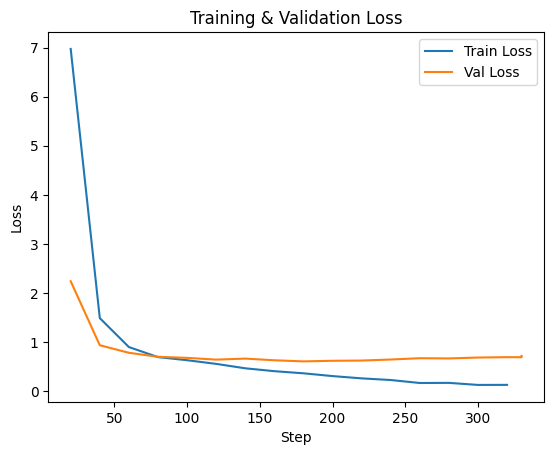

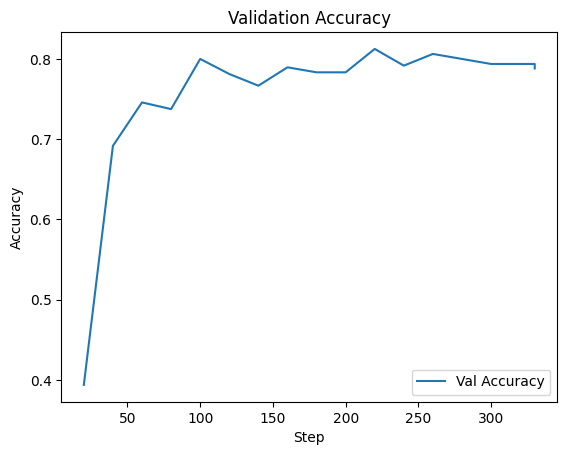

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

logs = trainer.state.log_history
df = pd.DataFrame(logs)

train_loss = df[df['loss'].notna()][['step','loss']]

eval_metrics = df[df['eval_loss'].notna()][['step','eval_loss','eval_accuracy']]

plt.figure()
plt.plot(train_loss['step'], train_loss['loss'], label='Train Loss')
plt.plot(eval_metrics['step'], eval_metrics['eval_loss'], label='Val Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(eval_metrics['step'], eval_metrics['eval_accuracy'], label='Val Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()
